In [2]:
import numpy as np                  
import pandas as pd                
import matplotlib.pyplot as plt    
import seaborn as sns
import mysql.connector
from mysql.connector import Error

In [3]:
def cargar_tablas_a_dataframes(host, database, user, password):
    """
    Se conecta a una base de datos MySQL y carga todas las tablas como DataFrames de Pandas
    con nombres dinámicos en el entorno global (ej. df_nombreTabla).
    """
    try:
        connection = mysql.connector.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )

        if connection.is_connected():
            cursor = connection.cursor()  # Creación de un cursor para ejecutar consultas SQL
            cursor.execute("SHOW TABLES")  # Se ejecuta la consulta "SHOW TABLES" para listar las tablas

            tablas = [tabla[0] for tabla in cursor.fetchall()]  # Se obtienen los nombres de las tablas

            for tabla in tablas:
                cursor.execute(f"SELECT * FROM {tabla}")  # Se extraen los datos de cada tabla
                columnas = [columna[0] for columna in cursor.description]  # Nombres de columnas
                globals()[f'df_{tabla}'] = pd.DataFrame(cursor.fetchall(), columns=columnas)  # DataFrame dinámico
                print(f'df_{tabla}')  # Mostrar el nombre del DataFrame creado

    except Error as e:
        print("Error while connecting to MySQL:", e)  # Manejo de errores

    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()  # Cierra el cursor
            connection.close()  # Cierra la conexión
            print("MySQL connection is closed")  # Mensaje de cierre

In [4]:
cargar_tablas_a_dataframes('212.227.90.6', 'Equip_11', 'Equipo11', 'E1q2u3i4p5o11')

df_RRHH
MySQL connection is closed


## Perfil Sociodemográfico

- Edad (variable numérica)
- Hijos (variable numérica)
- Estudios (variable categórica)

In [5]:
sociodemografico = df_RRHH[['ID', 'Age', 'Son', 'Education']].drop_duplicates(subset='ID').reset_index(drop=True)
sociodemografico.head()

,ID,Age,Son,Education
0,14,34,2,1
1,36,50,1,1
2,9,58,2,1
3,28,28,1,1
4,11,33,2,1


## Exploratory Data Analysis
* Estadísticos

In [6]:
sociodemografico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         36 non-null     int64 
 1   Age        36 non-null     int64 
 2   Son        36 non-null     int64 
 3   Education  36 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.3+ KB


* Cambio de tipo de datos

In [7]:
# Asegura que los valores de 'Son' sean enteros
sociodemografico['Son'] = pd.to_numeric(sociodemografico['Son'], errors='coerce')
sociodemografico['Son'] = sociodemografico['Son'].astype(int)


In [8]:
sociodemografico.describe()

,ID,Age,Son
count,36.000000,36.000000,36.000000
mean,18.500000,38.333333,1.138889
std,10.535654,7.917431,1.018480
min,1.000000,27.000000,0.000000
25%,9.750000,32.000000,0.000000
50%,18.500000,37.500000,1.000000
75%,27.250000,43.000000,2.000000
max,36.000000,58.000000,4.000000


## Visualizaciones

* Edad
* Hijos

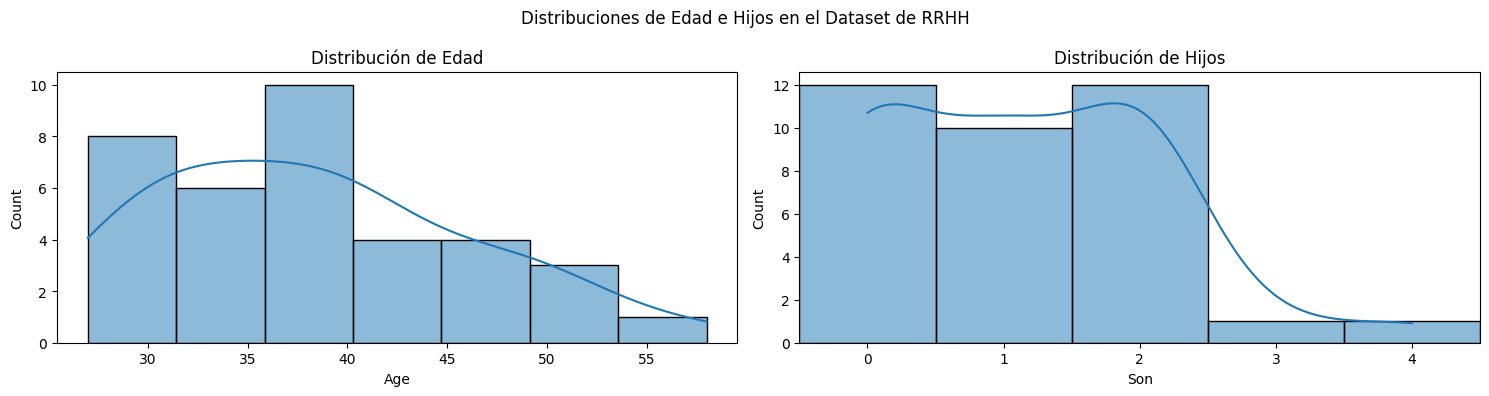

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(sociodemografico['Age'], kde=True, ax=axs[0])
axs[0].set_title("Distribución de Edad")


sns.histplot(
    sociodemografico['Son'],
    kde=True,
    ax=axs[1],
    bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
)
axs[1].set_title("Distribución de Hijos")
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xlim(-0.5, 4.5)
plt.suptitle("Distribuciones de Edad e Hijos en el Dataset de RRHH")

plt.tight_layout()
plt.show()

Proporción de empleados agrupados en 4 rangos de edad:

El grupo más numeroso es el de 30-39 años, que representa aproximadamente el 44% del total de empleados.
El segundo grupo más grande es el de 40-49 años, con un 31% de la plantilla.
Los empleados de 20-29 años constituyen cerca del 14%.
El grupo menos representado es el de 50-59 años, con solo un 11% de los empleados.

Conclusión:
La mayoría de los empleados tienen entre 30 y 49 años, lo que indica que la plantilla es mayoritariamente adulta joven. Hay poca presencia de empleados muy jóvenes (20-29) o cercanos a la jubilación (50-59). Esto puede sugerir estabilidad y experiencia en el equipo, pero también una menor diversidad generacional.

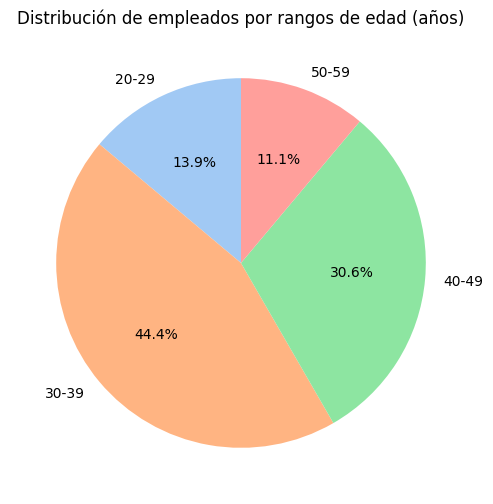

In [ ]:
age_bins = [20, 30, 40, 50, 60] 
age_labels = ['20-29', '30-39', '40-49', '50-59']
sociodemografico['Age_group'] = pd.cut(sociodemografico['Age'], bins=age_bins, labels=age_labels, right=False)

age_counts = sociodemografico['Age_group'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    age_counts,
    labels=age_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[0:len(age_labels)]
)
plt.title("Distribución de empleados por rangos de edad (años)")
plt.show()

Proporción de empleados según la cantidad de hijos que tienen:

La mayoría de los empleados tiene 0 o 2 hijos (cada grupo representa el 33.3% del total).
Un 27.8% de los empleados tiene 1 hijo.
Solo un 2.8% tiene 3 hijos y otro 2.8% tiene 4 hijos.

Conclusión:
La mayor parte de la plantilla tiene familias pequeñas (0, 1 o 2 hijos) o no tiene hijos. Son muy pocos los empleados con familias numerosas (3 o 4 hijos). Esto sugiere que la estructura familiar predominante entre los empleados es de familias pequeñas o sin hijos.

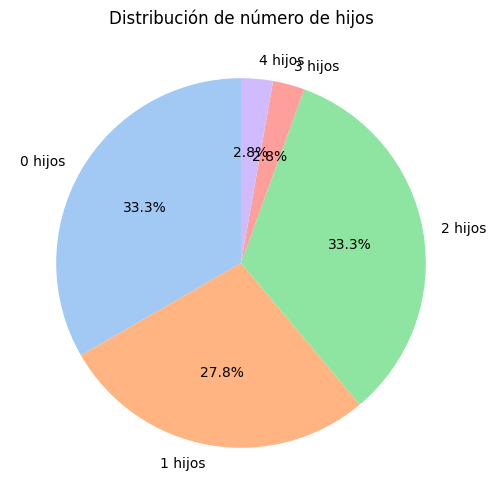

In [16]:
son_counts = sociodemografico['Son'].value_counts().sort_index()
labels = [f'{i} hijos' for i in son_counts.index]

plt.figure(figsize=(6, 6))
plt.pie(
    son_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[0:len(son_counts)]
)
plt.title("Distribución de número de hijos")
plt.show()

* Estudios

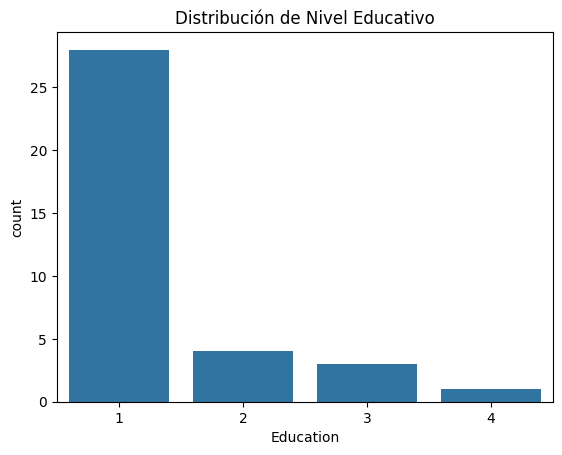

In [12]:
sns.countplot(
    data=sociodemografico,
    x='Education',
    order=[1, 2, 3, 4]
)
plt.title("Distribución de Nivel Educativo")
plt.show()

Proporción de empleados según su nivel educativo:

La gran mayoría de los empleados (77.8%) tiene el Nivel 1 (high school), es decir, el nivel educativo más bajo registrado en el dataset.

Un 11.1% de los empleados tiene Nivel 2 (graduate).

Un 8.3% tiene Nivel 3 (postgraduate).

Solo un 2.8% de los empleados ha alcanzado el Nivel 4 (master and doctor), el nivel educativo más alto.

Conclusión:
La plantilla está compuesta principalmente por empleados con bajo nivel educativo, y solo una minoría ha alcanzado estudios de posgrado o superiores. Esto puede influir en las competencias técnicas y profesionales del equipo, así como en las oportunidades de desarrollo y promoción interna.

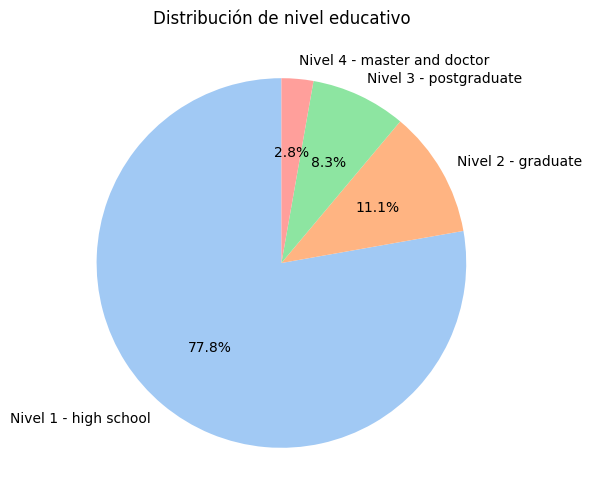

In [17]:
education_counts = sociodemografico['Education'].value_counts().sort_index()
labels = ['Nivel 1 - high school', 'Nivel 2 - graduate', 'Nivel 3 - postgraduate', 'Nivel 4 - master and doctor']  # Ajusta los nombres si tienes descripciones

plt.figure(figsize=(6, 6))
plt.pie(
    education_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[0:4]
)
plt.title("Distribución de nivel educativo")
plt.show()